In [11]:
import gc
import torch
import pandas as pd
import numpy as np
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt

import constants
from model.center_net import MyUNet,criterion
from car_dataset import CarDataset

In [2]:
train = pd.read_csv(constants.PATH + '/train.csv')
test = pd.read_csv(constants.PATH + '/sample_submission.csv')
train_images_dir = constants.PATH + 'train_images/{}.jpg'
test_images_dir = constants.PATH + 'test_images/{}.jpg'

df_train, df_dev = train_test_split(train, test_size=0.01, random_state=42)
df_test = test

In [3]:
# Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir, training=True)
dev_dataset = CarDataset(df_dev, train_images_dir, training=False)
test_dataset = CarDataset(df_test, test_images_dir, training=False)

BATCH_SIZE = 4
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [13]:
device = torch.device("cuda")
model = MyUNet(8).to(device)
model.load_state_dict(torch.load("model.pth"))

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [14]:
model.eval()

MyUNet(
  (base_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_pr

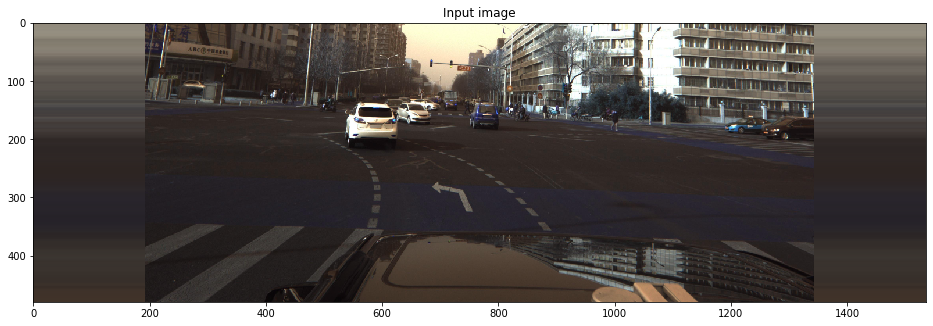

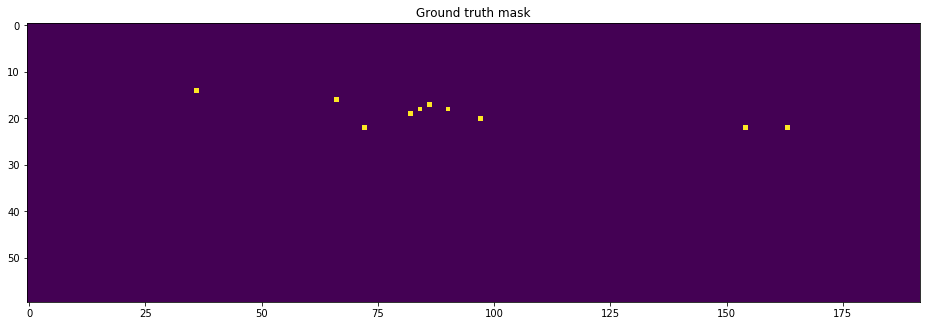

(60, 192)
-1.6693747


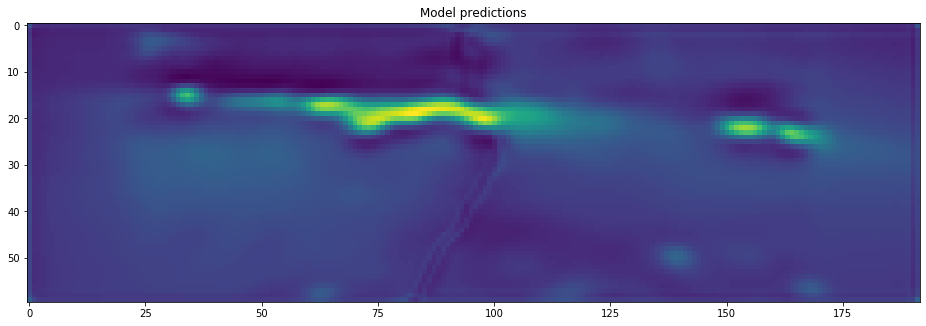

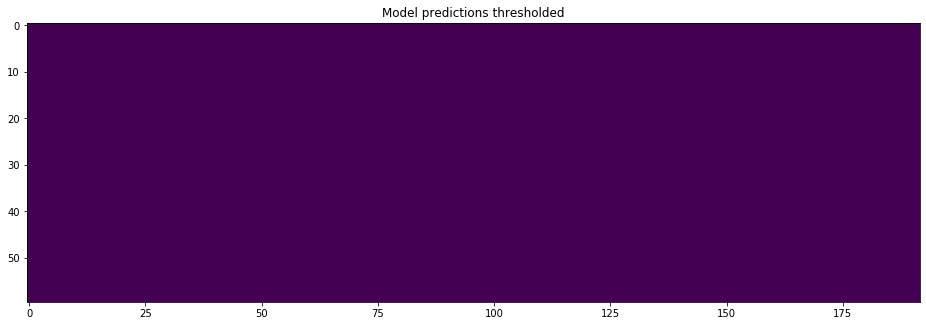

array([[-7.8010554, -8.755512 , -8.862148 , ..., -8.780254 , -8.841507 ,
        -7.7616534],
       [-8.536894 , -9.231911 , -9.147366 , ..., -8.921499 , -9.109713 ,
        -8.591933 ],
       [-8.605701 , -9.308705 , -9.205948 , ..., -8.745046 , -9.015691 ,
        -8.516947 ],
       ...,
       [-8.153625 , -8.745907 , -8.6919155, ..., -8.433933 , -8.712229 ,
        -8.305355 ],
       [-7.972461 , -8.601034 , -8.712697 , ..., -8.525803 , -8.672798 ,
        -8.276578 ],
       [-7.386352 , -8.108668 , -8.512927 , ..., -8.245838 , -8.293224 ,
        -7.3887753]], dtype=float32)

In [46]:
img, mask, regr = dev_dataset[0]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()
print(logits.shape)
print(np.max(logits))

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(logits > 0)
plt.show()

logits

output: (1, 8, 60, 192)


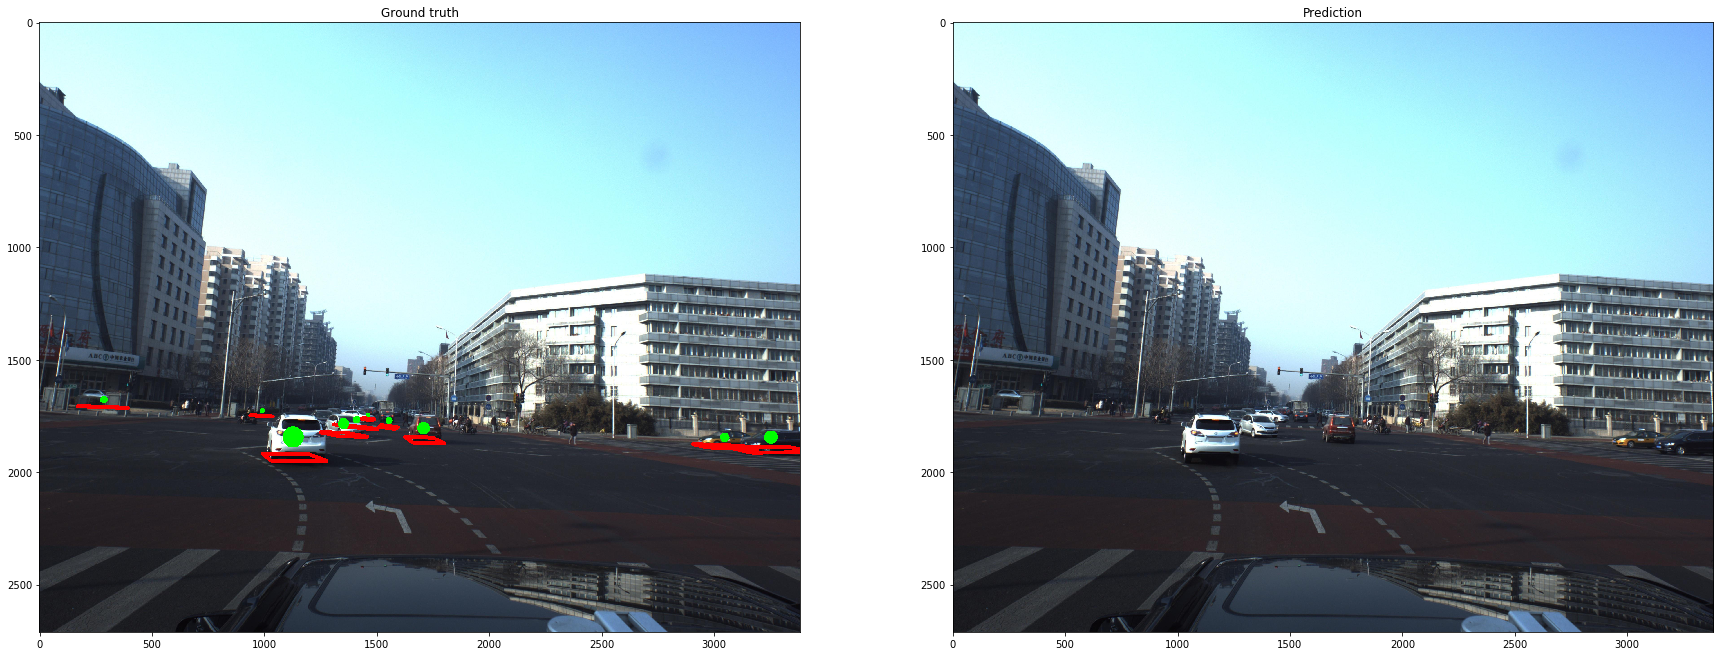

output: (1, 8, 60, 192)


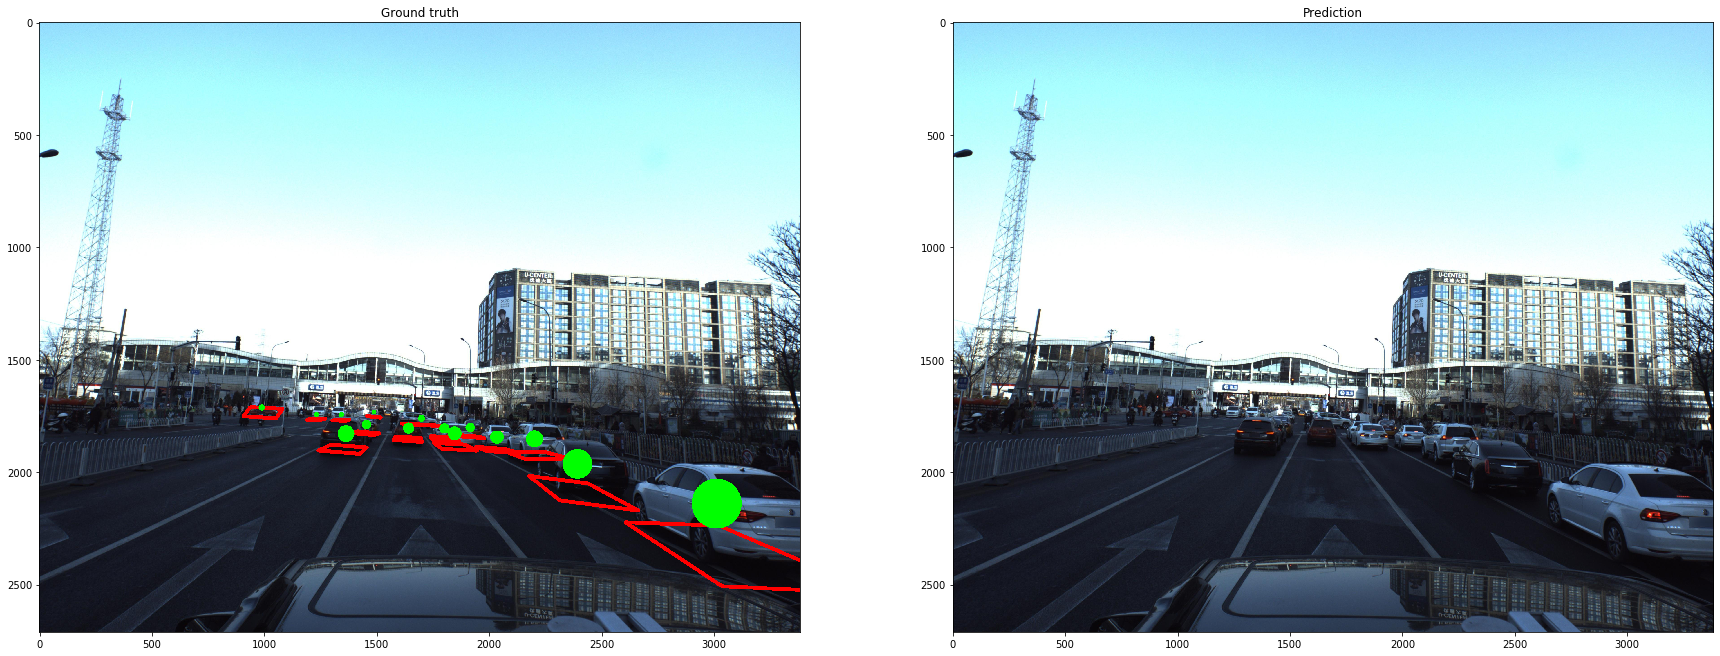

In [21]:
from util import *

gc.collect()

for idx in range(2):
    img, mask, regr = dev_dataset[idx]
    
    output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()
    print("output:", output.shape)
    coords_pred = extract_coords(output[0])
    coords_true = extract_coords(np.concatenate([mask[None], regr], 0))
    
    img = imread(train_images_dir.format(df_dev['ImageId'].iloc[idx]))
    
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(visualize(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(visualize(img, coords_pred))
    plt.show()

In [19]:
predictions = []

model.eval()

for img, _, _ in tqdm(test_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out)
        s = coords2str(coords)
        predictions.append(s)

100%|██████████| 506/506 [04:11<00:00,  2.01it/s]


In [23]:
test = pd.read_csv(constants.PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('predictions.csv', index=False)
test.head()

,ImageId,PredictionString
0,ID_18fb86d04,
1,ID_ce06d4dc1,
2,ID_afe07078f,
3,ID_37caf75aa,
4,ID_7655363ca,
